# Ressaut Hydraulique circulaire avec *jump detection* et *jump correction*.

Noé DANIEL & Richard PATEAU

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

Paramètres physiques et géométriques

In [3]:
g = 9.81
r_min = 0.01
r_max = 0.3
Nr    = 200
dr    = (r_max - r_min)/Nr
r     = np.linspace(r_min + 0.5*dr, r_max - 0.5*dr, Nr)

# État initial
h_init = 0.01 * np.ones(Nr)
h_init[0] = 0.02  
u_init = np.zeros(Nr)
u_init[0] = 1.0   

U_left = np.array([h_init[0], h_init[0]*u_init[0]])  # (h_in, h_in*u_in)

# Variable globale U = (h, hu)
U = np.zeros((2, Nr))
U[0, :] = h_init
U[1, :] = h_init*u_init

Paramètre de temps. *En veillant à ce que $\mathrm{d}t$ vérifie la CFL.*

In [4]:
t = 0.0
t_max = 5.0        
dt = 4e-4

In [5]:
# Seuil de convergence : si ||U_new - U_old||_{∞} < epsilon => stop
epsilon = 1e-9

# Hauteur minimale (zones sèches)
h_threshold = 1e-5

Calcul du flux & du terme source.

In [6]:
def compute_flux(U):
    h  = U[0,:]
    hu = U[1,:]
    u  = np.zeros_like(h)
    mask = (h>1e-10)
    u[mask] = hu[mask]/h[mask]
    F = np.zeros_like(U)
    F[0,:] = h * u
    F[1,:] = h * u**2 + 0.5*g*h**2
    return F

def source_term(U, r):
    h  = U[0,:]
    hu = U[1,:]
    u  = np.zeros_like(h)
    mask = (h>1e-10)
    u[mask] = hu[mask]/h[mask]

    S = np.zeros_like(U)
    S[0,:] = - (h*u)/r
    S[1,:] = - (h*u**2 + 0.5*g*h**2)/r
    return S

Calcul via flux de Rusanov

In [7]:
def flux_rusanov(U_L, U_R):
    F_L = compute_flux(U_L.reshape(2,1))[:,0]
    F_R = compute_flux(U_R.reshape(2,1))[:,0]
    hL, huL = U_L
    hR, huR = U_R

    uL = huL/hL if hL>1e-10 else 0.0
    uR = huR/hR if hR>1e-10 else 0.0

    cL = np.sqrt(g*hL)
    cR = np.sqrt(g*hR)

    smax = max(abs(uL)+cL, abs(uR)+cR)
    return 0.5*(F_L + F_R) - 0.5*smax*(U_R - U_L)

Fonction de passage de $t$ à $t+dt$

In [8]:
def update_timestep(U, dt):
    Nr_local = U.shape[1]
    Fnum = np.zeros((2, Nr_local+1))
    for j in range(1, Nr_local):
        U_L = U[:, j-1]
        U_R = U[:, j]
        Fnum[:, j] = flux_rusanov(U_L, U_R)

    # BC gauche (Dirichlet) + droite (simple)
    Fnum[:, 0]         = flux_rusanov(U_left, U[:, 0])
    Fnum[:, Nr_local]  = flux_rusanov(U[:, Nr_local-1], U[:, Nr_local-1])

    S_loc = source_term(U, r)

    U_new = U.copy()
    for j in range(Nr_local):
        U_new[:, j] = ( U[:, j]
                        - (dt/dr)*(Fnum[:, j+1] - Fnum[:, j])
                        + dt * S_loc[:, j] )

    # Forçage si h < h_threshold
    for j in range(Nr_local):
        if U_new[0, j] < h_threshold:
            U_new[0, j] = 0.0
            U_new[1, j] = 0.0

    return U_new

Tracking de la position du *jump*

La fonction trouve l'indice i (et la coord r[i]) où le flot passe de supercritique (Fr>1) à sous-critique (Fr<1).
Retourne (i, r[i]) ou (None, None) si non trouvé.

In [9]:
def find_jump_location(U):

    Nr_local = U.shape[1]
    h  = U[0,:]
    hu = U[1,:]
    Fr = np.zeros_like(h)
    mask = (h>1e-10)
    Fr[mask] = np.abs(hu[mask]/h[mask]) / np.sqrt(g*h[mask])

    for i in range(1, Nr_local):
        if Fr[i-1]>1.0 and Fr[i]<1.0:
            return i, r[i]
    return None, None

Boucle de simulation

In [10]:
t_current = 0.0
dt        = 1e-4
t_max     = 5.0
epsilon   = 1e-9   # convergence threshold

U_current = np.zeros((2, Nr))
U_current[0,:] = h_init
U_current[1,:] = h_init * u_init

time_list    = []
U_snapshots  = []      
jump_positions = []    
diff_list     = []     

# Initialisation
time_list.append(t_current)
U_snapshots.append(U_current.copy())
idx_jump, r_jump = find_jump_location(U_current)
jump_positions.append(r_jump if r_jump is not None else None)
diff_list.append(0.0)

# Variable d'arrêt
finished = False

while not finished:
    
    U_old = U_current.copy()
    U_new = update_timestep(U_current, dt)

    # Norme de la différence pour le test de convergence
    diff = np.max(np.abs(U_new - U_old))
    
    # MAJ
    U_current[:] = U_new
    t_current += dt
    
    # Arrêt si aucun mouvement ou si t > t_max
    if diff < epsilon:
        print(f"Convergence atteinte: diff={diff:.2e}, t={t_current:.4f}")
        finished = True
    if t_current >= t_max:
        print(f"t={t_current:.4f} >= t_max => on arrête")
        finished = True
    
    # Stockage
    time_list.append(t_current)
    U_snapshots.append(U_current.copy())
    diff_list.append(diff)
    
    # Position du jump
    idx_jump, r_jump = find_jump_location(U_current)
    jump_positions.append(r_jump if r_jump else None)

    if len(jump_positions) > 1 and jump_positions[-1] is not None and jump_positions[-2] is not None:
        if r_jump < jump_positions[-2]:
            print("Jump a reculé !")
            finished = True

    

Jump a reculé !


### Visualisation des résultats

On peut d'abord regarder l'évolution de la position du jump au cours du temps

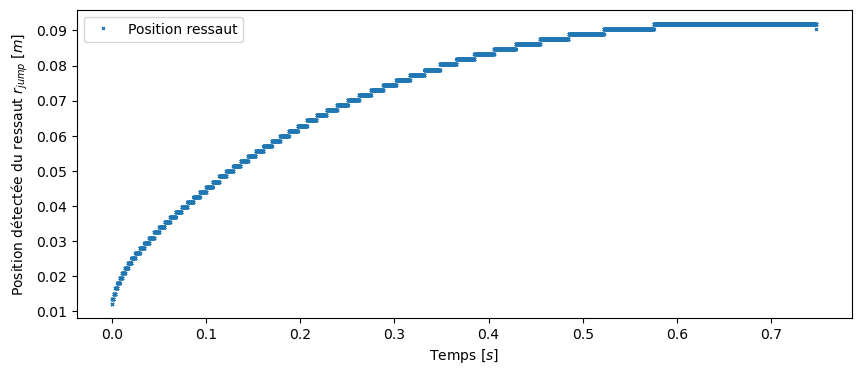

In [12]:
plt.figure(figsize=(10, 4))

jump_positions_float = [jp if jp is not None else np.nan for jp in jump_positions]
plt.plot(time_list, jump_positions_float, 'x', label='Position ressaut', markersize=2)
plt.xlabel(r'Temps [$s$]')
plt.ylabel(r'Position détectée du ressaut $r_{jump}$ [$m$]')
plt.legend()

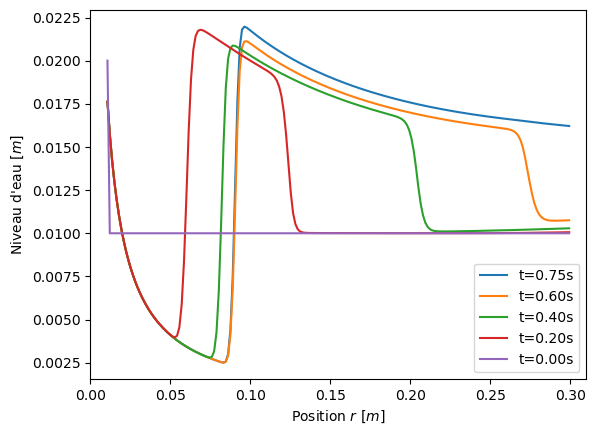

In [13]:
import matplotlib.pyplot as plt

times_of_interest = [0.0, 0.2, 0.4, 0.6, 0.75]  # ex
fig, ax = plt.subplots()

for T_desired in reversed(times_of_interest):
    # On cherche dans time_list l'indice le plus proche
    idx = np.argmin(np.abs(np.array(time_list) - T_desired))
    # On récupère U
    U_choisi = U_snapshots[idx]
    h_plot   = U_choisi[0,:]
    
    ax.plot(r, h_plot, label=f"t={time_list[idx]:.2f}s")

ax.set_xlabel(r'Position $r$ [$m$]')
ax.set_ylabel(r"Niveau d'eau [$m$]")

ax.set_xlim([0, r_max+0.01])

ax.legend()
plt.show()

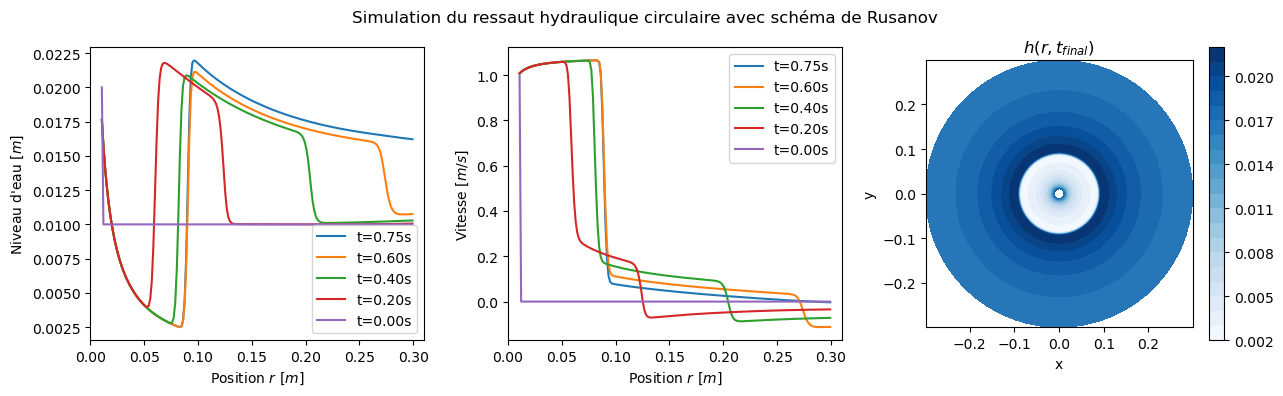

In [14]:
times_of_interest = [0.0, 0.2, 0.4, 0.6, 0.75]

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

# Subplot 1: Niveau d'eau

for T_desired in reversed(times_of_interest):
    # On cherche dans time_list l'indice le plus proche
    idx = np.argmin(np.abs(np.array(time_list) - T_desired))
    # On récupère U
    U_choisi = U_snapshots[idx]
    h_plot   = U_choisi[0,:]
    
    axs[0].plot(r, h_plot, label=f"t={time_list[idx]:.2f}s")

axs[0].set_xlabel(r'Position $r$ [$m$]')
axs[0].set_ylabel(r"Niveau d'eau [$m$]")

axs[0].set_xlim([0, r_max+0.01])

axs[0].legend()

# Subplot 2: Vitesse moyenne
for T_desired in reversed(times_of_interest):
    # On cherche dans time_list l'indice le plus proche
    idx = np.argmin(np.abs(np.array(time_list) - T_desired))
    # On récupère U
    U_choisi = U_snapshots[idx]
    u_plot   = U_choisi[1,:]/U_choisi[0,:]
    
    axs[1].plot(r, u_plot, label=f"t={time_list[idx]:.2f}s")

axs[1].set_xlabel(r'Position $r$ [$m$]')
axs[1].set_ylabel(r"Vitesse [$m/s$]")

axs[1].set_xlim([0, r_max+0.01])

axs[1].legend()

nTheta = 60
theta_arr = np.linspace(0, 2*np.pi, nTheta)
R_mat, TH_mat = np.meshgrid(r, theta_arr)
X_mat = R_mat * np.cos(TH_mat)
Y_mat = R_mat * np.sin(TH_mat)

def get_height_2D(U):
    h_r = U[0,:]
    h2D = np.tile(h_r, (nTheta,1))
    return h2D

# Récupérer les données de la dernière étape de la simulation
U_final = U_snapshots[-1]
h_final = U_final[0, :]

# Créer le contour plot
h2d_final = get_height_2D(U_final)
cont = axs[2].contourf(X_mat, Y_mat, h2d_final, levels=20, cmap='Blues')
cb = fig.colorbar(cont, ax=axs[2])
axs[2].set_aspect('equal', 'box')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('$h(r,t_{final})$')


plt.suptitle("Simulation du ressaut hydraulique circulaire avec schéma de Rusanov")
plt.tight_layout()
plt.savefig("ressaut_circulaire_rusanov.svg")


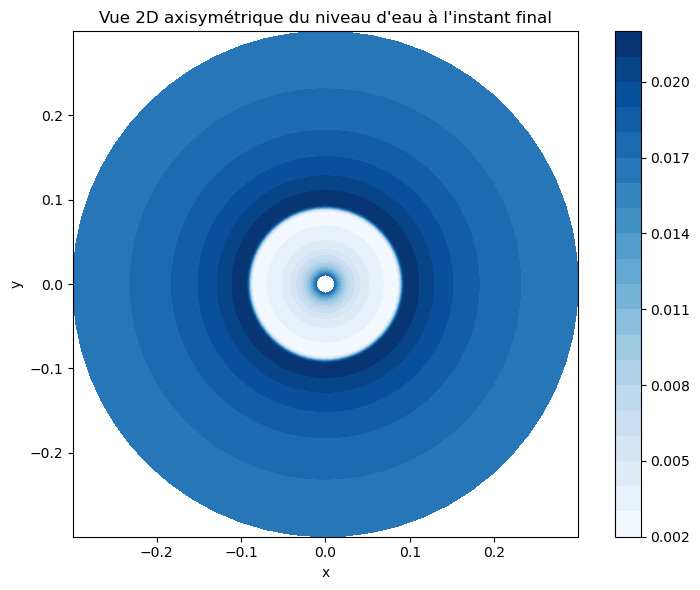

In [47]:
nTheta = 60
theta_arr = np.linspace(0, 2*np.pi, nTheta)
R_mat, TH_mat = np.meshgrid(r, theta_arr)
X_mat = R_mat * np.cos(TH_mat)
Y_mat = R_mat * np.sin(TH_mat)

def get_height_2D(U):
    h_r = U[0,:]
    h2D = np.tile(h_r, (nTheta,1))
    return h2D

# Récupérer les données de la dernière étape de la simulation
U_final = U_snapshots[-1]
h_final = U_final[0, :]

# Créer le contour plot
fig, ax_cont = plt.subplots(figsize=(8, 6))
h2d_final = get_height_2D(U_final)
cont = ax_cont.contourf(X_mat, Y_mat, h2d_final, levels=20, cmap='Blues')
cb = fig.colorbar(cont, ax=ax_cont)
ax_cont.set_aspect('equal', 'box')
ax_cont.set_xlabel('x')
ax_cont.set_ylabel('y')
ax_cont.set_title('Vue 2D axisymétrique du niveau d\'eau à l\'instant final')

plt.tight_layout()
plt.show()